<a href="https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Assignment%207/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #07

Xuannag Zhu

Description: Test the hypothesis that less focused part or background still has influence on ResNet50's classification result, with Grad-CAM.

https://github.com/xazhu9/AIPI-590/blob/main/Assignment%207/Assignment_7.ipynb

H0: The less focused part or background still has influence on ResNet50's classification.

H1: The less focused part or background has no influence on ResNet50's classification.

In this approach, I use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the areas of the input image that the model focuses on during classification. The heatmap generated by Grad-CAM highlights the most important regions (with higher activation values) that influence the model's decision. After generating the heatmap, I selectively occlude the less important regions (areas with lower activation values) based on a chosen threshold, which allows us to assess whether the less influencial parts or the background still have effect on model's classification. By comparing the model's predictions before and after occluding these low-attention areas, we can evaluate the extent to which the model depends on non-essential features, providing insight into its robustness and interpretability.

In [ ]:
!rm -rf AIPI-590
!git clone https://github.com/xazhu9/AIPI-590.git
!pip install grad-cam

Cloning into 'AIPI-590'...
remote: Enumerating objects: 6114, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 6114 (delta 45), reused 35 (delta 11), pack-reused 6004 (from 1)
Receiving objects: 100% (6114/6114), 64.31 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Updating files: 100% (5016/5016), done.


In [ ]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np


Load model and dataset

In [ ]:
# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the TinyImageNet dataset
dataset = datasets.ImageFolder("/content/AIPI-590/TinyImageNet", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Grad-CAM

Original Classification: 398


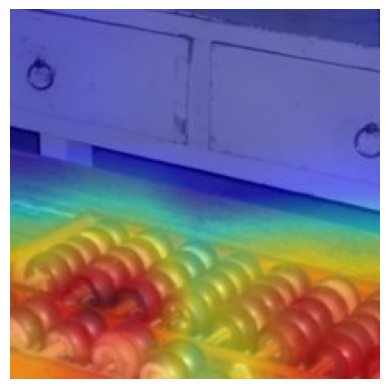

In [ ]:
# Define Grad-CAM
target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

# Get an image
images, labels = next(iter(dataloader))
input_tensor = images[0].unsqueeze(0)  # Get a single image

# Classify the original image
output = model(input_tensor)
predicted_class_original = torch.argmax(output, 1).item()
print(f"Original Classification: {predicted_class_original}")

# Compute Grad-CAM without specifying target_category
grayscale_cam = cam(input_tensor=input_tensor)

# Visualize the Grad-CAM heatmap
input_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Normalize
visualization = show_cam_on_image(input_image, grayscale_cam[0], use_rgb=True)

# Display the Grad-CAM result
plt.imshow(visualization)
plt.axis('off')
plt.show()


The Grad-CAM heatmap highlights the regions of the input image that the model most strongly focuses on when making its classification decision. In this visualization, warmer colors (e.g., red and orange) represent areas with higher activation values, indicating that the model considers these regions more important for its prediction. Cooler colors (e.g., blue) represent areas with lower activation values, showing regions that the model deems less relevant to the classification task.

Hide the low-activation areas

Classification after occlusion: 398


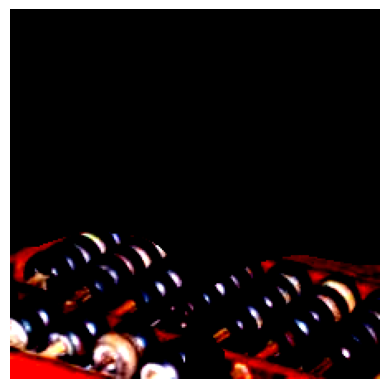

In [ ]:
# Occlude low-activation areas from Grad-CAM heatmap
def occlude_low_attention_areas(image, cam_map, threshold=0.2):
    """Occlude regions with activation values below the threshold, keeping the high-attention areas"""
    image = image.clone()
    cam_map = np.array(cam_map)

    # Set the threshold and occlude regions with activation values below the threshold
    low_attention_mask = cam_map >= threshold  # Keep high-activation areas (note the logic reversal)
    low_attention_mask = np.expand_dims(low_attention_mask, axis=0)  # Add channel dimension
    low_attention_mask = torch.tensor(low_attention_mask).float().to(image.device)  # Convert to tensor and ensure device compatibility

    # Only occlude low-activation areas by setting them to 0
    image = image * low_attention_mask
    return image

# Occlude less-attended areas
occluded_image = occlude_low_attention_areas(images[0], cam_map=grayscale_cam[0], threshold=0.6)

# Recompute classification for the occluded image
output = model(occluded_image.unsqueeze(0))
predicted_class = torch.argmax(output, 1).item()
print(f"Classification after occlusion: {predicted_class}")

# Display the occluded image
plt.imshow(occluded_image.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()


After comparing the classification results before and after occluding these low-importance regions, we found that occluding these areas had no significant impact on the model's classification accuracy. This suggests that the model's decision-making process is robust and primarily relies on the critical areas (highlighted by the heatmap) to classify the image correctly, while the background or less relevant regions do not significantly influence the outcome.

Results of Hypothesis Testing:

Based on these findings, we reject the null hypothesis (H0) and accept the alternative hypothesis (H1), concluding that the less focused part or background has no influence on ResNet50's classification. The model predominantly relies on the key, high-activation regions of the image (as highlighted by Grad-CAM) to make accurate predictions, and background or low-importance areas do not contribute to the classification.